In [1]:

import ipympl
import numpy as np
np.random.seed(42)
import pandas as pd
import math
import scipy.io
#import matplotlib
#matplotlib.use('nbagg')
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean 
from sklearn.model_selection import train_test_split
from keras.callbacks.callbacks import EarlyStopping
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.python.keras.models import Model
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
mat = scipy.io.loadmat('cardio.mat')
#mat = scipy.io.loadmat('satellite.mat')
#mat = scipy.io.loadmat('ionosphere.mat')


In [3]:
epochs = 300
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2)]

In [4]:
#functions to calculate best threshold based on test data
def calc_res(df_error,x,test_data):
    #taking the mean value of the reconstruction error as out seperation point for inliers and outliers
    outliers_array = df_error.index[df_error.reconstruction_error > x].tolist()
    test_y2 = test_data.to_numpy()
    #print(outliers2)
    accuracy_positive_count2 = 0
    accuracy_negative_count2 = 0
    tess = np.take(test_y2,outliers_array)
    unique, counts = np.unique(tess, return_counts=True)
    #print(dict(zip(unique, counts)))
    if(counts.shape[0]<2):
        return 0
    accuracy_negative_count2 = counts[1]
    accuracy_positive_count2 = abs((test_y2.shape[0]-len(outliers_array)))

    accuracy_positive2 = accuracy_positive_count2/(inliers_test)
    accuracy_negative2 = accuracy_negative_count2/(outliers_test)
    if(accuracy_positive2>1):accuracy_positive2 = 1
    if(accuracy_negative2>1):accuracy_negative2 = 1
    return math.sqrt(accuracy_positive2*accuracy_negative2)

def find_max(f,max_val,df_error,test_data):
    maxx=0
    patience = 2
    old = 0
    maxi = 0
    #first pass
    iters = 0
    for i in np.arange(0,1,0.1):
        #print(i)
        iters = iters+1
        new = f(df_error,i,test_data)
        
        if(new>maxx):
            maxi = i
            maxx = new
            #print(maxi)
        else:
            if(patience<=0):
                break;
            if((old-new)<=0):
                patience = patience - 1;
            
        old = new
    
    #second pass
    maxx=0
    patience = 2
    old = 0
    #iters = 0
    for i in np.arange(maxi-0.1,maxi+0.1,0.01):
        iters = iters+1
        new = f(df_error,i,test_data)
        
        if(new>maxx):
            maxi = i
            maxx = new
            #print(maxi)
        else:
            if(patience<=0):
                break;
            if((old-new)<=0):
                patience = patience - 1;
            
        old = new
    
    #third pass
    maxx=0
    patience = 2
    old = 0
    #iters = 0
    for i in np.arange(maxi-0.01,maxi+0.01,0.001):
        iters = iters+1
        new = f(df_error,i,test_data)
        
        if(new>maxx):
            maxi = i
            maxx = new
            #print(maxi)
        else:
            if(patience<=0):
                break;
            if((old-new)<=0):
                patience = patience - 1;
            
        old = new
    print('Iterations')
    print(iters)
    return maxi

def print_res(x,df_error,test_data):
    #taking the mean value of the reconstruction error as out seperation point for inliers and outliers
    outliers_array = df_error.index[df_error.reconstruction_error > x].tolist()
    test_y2 = test_data.to_numpy()
    #print(outliers2)
    accuracy_positive_count2 = 0
    accuracy_negative_count2 = 0
    tess = np.take(test_y2,outliers_array)
    unique, counts = np.unique(tess, return_counts=True)
    #print(dict(zip(unique, counts)))
    accuracy_negative_count2 = counts[1]
    accuracy_positive_count2 = abs((test_y2.shape[0]-len(outliers_array)))

    print("Correct predictions")
    print(accuracy_positive_count2+accuracy_negative_count2)
    
    accuracy_positive2 = accuracy_positive_count2/(inliers_test)
    accuracy_negative2 = accuracy_negative_count2/(outliers_test)
    if(accuracy_positive2>1):accuracy_positive2 = 1
    if(accuracy_negative2>1):accuracy_negative2 = 1
    print("Test Accuracy")
    print(math.sqrt(accuracy_positive2*accuracy_negative2))

    print("Number of Outliers found in Test")
    print(accuracy_negative_count2)
    print("Number of Outliers acutally in Test")
    print(outliers_test)
    print("Outlier accuracy")
    print(accuracy_negative_count2/outliers_test)
    print("Number of Inliers found in Test")
    print(accuracy_positive_count2)
    print("Number of Inliers acutally in Test")
    print(inliers_test)
    print("Inlier accuracy")
    print(accuracy_positive_count2/inliers_test)
    print("Number of Inliers classified as Outliers")
    print(counts[0])
    return 

In [5]:
Xtemp = mat['X']
ytemp = mat['y']
X = np.array(Xtemp)
y = np.array(ytemp)
print(X.shape)
y = y.reshape(X.shape[0],)
print(y.shape)

(1831, 21)
(1831,)


In [6]:
outliers = 0
clean_data = []
contam_data = []

for i in range(y.shape[0]):
    if(y[i]==1.0):
        outliers+=1;
        contam_data.append(X[i])
    else:
        clean_data.append(X[i])
      
print("Total number of outliers in Dataset")        
print(outliers)
contam = outliers/y.shape[0]
print("Contamination in Dataset")
print(contam)
clean_data = np.array(clean_data)
contam_data = np.array(contam_data)
print(clean_data.shape)
clean_data2 = clean_data.copy()
contam_data2 = contam_data.copy()
# test_data_full = []
# for i in range(176):
#     test_data_full.append(contam_data[i])
# one = np.ones(176)
# test_data_full = np.array(test_data_full)

# test_data_full= np.append(test_data_full,one,1)

# print(test_data_full.shape)

Xy = X.copy()
Xy.shape
Xy = np.array(Xy)
Xy = np.insert(Xy, X.shape[1], y, axis=1)
#print(Xy.shape)
count = outliers
count2 = outliers

#selecting all the outliers from dataset
test_data =[]
for i in range(Xy.shape[0]):
    if(Xy[i,X.shape[1]]==1 and count>0):
        test_data.append(Xy[i])
        count = count-1
    
test_data = np.array(test_data)

#selecting random inliers from train data and removing them
indexes = np.random.choice(clean_data.shape[0], outliers, replace=False)

random_clean_data = clean_data[indexes, :]
random_clean_data = np.hstack((random_clean_data, np.zeros((random_clean_data.shape[0], 1), dtype=random_clean_data.dtype)))

indexes = indexes.reshape(outliers,1)

#deleting the values from train data
clean_data = np.delete(clean_data,indexes,0)
#print(clean_data)                
test_data = np.append(test_data,random_clean_data,axis=0)
np.random.shuffle(test_data)

print("test_data.shape")
print(test_data.shape)
#print(test_data.shape)
test_x = test_data[:,:test_data.shape[1]-1]
test_y = test_data[:,test_data.shape[1]-1]
#print(test_x.shape)
#print(test_y.shape)
test_x = pd.DataFrame(test_x)
test_y = pd.DataFrame(test_y)

print("train_data.shape")                    
print(clean_data.shape)                         

Total number of outliers in Dataset
176
Contamination in Dataset
0.0961223375204806
(1655, 21)
test_data.shape
(352, 22)
train_data.shape
(1479, 21)


In [7]:
X_train, X_test = train_test_split(clean_data2,  test_size=0.5, random_state=42)
X_test = np.append(X_test,np.zeros((X_test.shape[0],1),dtype='float64'),axis=1)

inliers_test = X_test.shape[0]

contam_new = contam_data2.shape[0]/X_test.shape[0]
contam_data3 = np.append(contam_data2,np.ones((contam_data2.shape[0],1),dtype='float64'),axis=1)
outliers_test = contam_data3.shape[0]
X_test = np.append(X_test,contam_data3,axis=0)
np.random.shuffle(X_test)
Xy_test = X_test.copy
y_test = X_test[:,X_test.shape[1]-1]
#print(y_test.shape)
X_test = np.delete(X_test,X_test.shape[1]-1,axis=1)
#print(X_test.shape)

X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
print("Number of Outliers in Test")
print(outliers_test)
print("Number of Inliers in Test")
print(inliers_test)


Number of Outliers in Test
176
Number of Inliers in Test
828


In [8]:
scaler = StandardScaler(-1,1)
clean_data = scaler.fit_transform(clean_data)
test_x  = scaler.transform(test_x)
clean_data = pd.DataFrame(clean_data)

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)
clean_data = pd.DataFrame(clean_data)

In [9]:
#deep autoencoder
inputs = Input(shape=(X.shape[1],))
#encoded = Dense(50, activation='relu')(inputs)
encoded = Dense(100, activation='relu'
               # ,activity_regularizer=regularizers.l1(1e-3)
               ,kernel_regularizer=l2(0.000001)
                ,bias_regularizer=l2(0.000001)
               )(inputs)
encoded = Dense(5, activation='relu'
#                 ,
                ,kernel_regularizer=l2(0.000001)
                ,bias_regularizer=l2(0.000001)
               )(encoded)

decoded = Dense(100, activation='relu'
                #,activity_regularizer=regularizers.l1(1e-3)
               ,kernel_regularizer=l2(0.000001)
                ,bias_regularizer=l2(0.000001)
               )(encoded)
#decoded = Dense(21, activation='relu')(decoded)
decoded = Dense(X.shape[1], activation='tanh')(decoded)


In [10]:
autoencoder = Model(inputs, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_train, X_train,
                epochs=epochs,
                callbacks=callbacks,
                batch_size = 256,
                shuffle = True,
                validation_split=0.4
               )

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 21)]              0         
_________________________________________________________________
dense (Dense)                (None, 100)               2200      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               600       
_________________________________________________________________
dense_3 (Dense)              (None, 21)                2121      
Total params: 5,426
Trainable params: 5,426
Non-trainable params: 0
_________________________________________________________________
Train on 496 samples, validate on 331 samples
Epoch 1/300
496/496 [==============================] - 1s 2ms/sample - loss: 0.

496/496 [==============================] - 0s 34us/sample - loss: 0.0391 - val_loss: 0.0433
Epoch 70/300
496/496 [==============================] - 0s 32us/sample - loss: 0.0385 - val_loss: 0.0427
Epoch 71/300
496/496 [==============================] - 0s 36us/sample - loss: 0.0379 - val_loss: 0.0421
Epoch 72/300
496/496 [==============================] - 0s 30us/sample - loss: 0.0373 - val_loss: 0.0416
Epoch 73/300
496/496 [==============================] - 0s 32us/sample - loss: 0.0367 - val_loss: 0.0411
Epoch 74/300
496/496 [==============================] - 0s 30us/sample - loss: 0.0362 - val_loss: 0.0405
Epoch 75/300
496/496 [==============================] - 0s 30us/sample - loss: 0.0357 - val_loss: 0.0401
Epoch 76/300
496/496 [==============================] - 0s 34us/sample - loss: 0.0352 - val_loss: 0.0396
Epoch 77/300
496/496 [==============================] - 0s 32us/sample - loss: 0.0348 - val_loss: 0.0392
Epoch 78/300
496/496 [==============================] - 0s 30us/samp

496/496 [==============================] - 0s 32us/sample - loss: 0.0232 - val_loss: 0.0292
Epoch 147/300
496/496 [==============================] - 0s 30us/sample - loss: 0.0231 - val_loss: 0.0292
Epoch 148/300
496/496 [==============================] - 0s 34us/sample - loss: 0.0230 - val_loss: 0.0291
Epoch 149/300
496/496 [==============================] - 0s 32us/sample - loss: 0.0229 - val_loss: 0.0290
Epoch 150/300
496/496 [==============================] - 0s 32us/sample - loss: 0.0228 - val_loss: 0.0290
Epoch 151/300
496/496 [==============================] - 0s 36us/sample - loss: 0.0228 - val_loss: 0.0289
Epoch 152/300
496/496 [==============================] - 0s 32us/sample - loss: 0.0227 - val_loss: 0.0289
Epoch 153/300
496/496 [==============================] - 0s 36us/sample - loss: 0.0226 - val_loss: 0.0288
Epoch 154/300
496/496 [==============================] - 0s 32us/sample - loss: 0.0225 - val_loss: 0.0288
Epoch 155/300
496/496 [==============================] - 0s 

In [11]:
#encoded_data = encoder.predict(test_x)
decoded_data = autoencoder.predict(X_test)

mse = np.mean((np.power(X_test - decoded_data, 2)), axis=1)

In [12]:
mse = mse.reshape(-1, 1)
print(mse.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
mse = scaler.fit_transform(mse)



(1004, 1)


In [13]:
df_error = pd.DataFrame({'reconstruction_error': mse[:,0]})
df_error.describe()

,reconstruction_error
count,1004.000000
mean,0.045597
std,0.086489
min,0.000000
25%,0.009972
50%,0.019745
75%,0.041900
max,1.000000


In [14]:
y_pred_bool = np.argmax(decoded_data, axis=1)
print(classification_report(y_test, y_pred_bool, zero_division=1))

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve



              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00       828
         1.0       0.00      0.00      0.00       176
         3.0       0.00      1.00      0.00         0
         4.0       0.00      1.00      0.00         0
         6.0       0.00      1.00      0.00         0
         7.0       0.00      1.00      0.00         0
         9.0       0.00      1.00      0.00         0
        11.0       0.00      1.00      0.00         0
        12.0       0.00      1.00      0.00         0
        13.0       0.00      1.00      0.00         0
        17.0       0.00      1.00      0.00         0
        20.0       0.00      1.00      0.00         0

    accuracy                           0.00      1004
   macro avg       0.08      0.83      0.00      1004
weighted avg       0.82      0.00      0.00      1004



In [15]:
import time
start_time = time.time()

if(df_error.reconstruction_error.max()>2):
    maxi = find_max(calc_res,round(df_error.reconstruction_error.max()/2),df_error,y_test)
else:
    maxi = find_max(calc_res,df_error.reconstruction_error.max(),df_error,y_test)

#print(maxi)
#print(calc_res(maxi))

print("--- %s seconds ---" % (time.time() - start_time))

Iterations
34
--- 0.02100062370300293 seconds ---


In [16]:
#deep autoencoder
encoded2 = Dense(30, activation='relu'
                ,activity_regularizer=regularizers.l1(1e-3)
                )(inputs)
#encoded2 = Dense(round(X.shape[1]/4), activation='relu')(encoded2)
encoded2 = Dense(20, activation='relu')(encoded2)
encoded2 = Dense(10, activation='relu')(encoded2)

decoded2 = Dense(20, activation='relu')(encoded2)
#decoded2 = Dense(round(X.shape[1]/4), activation='relu')(encoded2)
decoded2 = Dense(30, activation='relu'
                #,activity_regularizer=regularizers.l1(1e-3)
                )(decoded2)
decoded2 = Dense(X.shape[1], activation='tanh')(decoded2)

autoencoder2 = Model(inputs, decoded2)
autoencoder2.summary()
autoencoder2.compile(optimizer='adam', loss='mse')

autoencoder2.fit(X_train, X_train,
                epochs=epochs,
                batch_size=256,
                shuffle=False,
                callbacks=callbacks,
                validation_split=0.4
               )

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 21)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 30)                660       
_________________________________________________________________
dense_5 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_7 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_8 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_9 (Dense)              (None, 21)                651 

496/496 [==============================] - 0s 32us/sample - loss: 0.0788 - val_loss: 0.0836
Epoch 67/300
496/496 [==============================] - 0s 34us/sample - loss: 0.0778 - val_loss: 0.0825
Epoch 68/300
496/496 [==============================] - 0s 34us/sample - loss: 0.0767 - val_loss: 0.0814
Epoch 69/300
496/496 [==============================] - 0s 34us/sample - loss: 0.0756 - val_loss: 0.0802
Epoch 70/300
496/496 [==============================] - 0s 36us/sample - loss: 0.0745 - val_loss: 0.0790
Epoch 71/300
496/496 [==============================] - 0s 34us/sample - loss: 0.0734 - val_loss: 0.0779
Epoch 72/300
496/496 [==============================] - 0s 34us/sample - loss: 0.0723 - val_loss: 0.0768
Epoch 73/300
496/496 [==============================] - 0s 30us/sample - loss: 0.0712 - val_loss: 0.0758
Epoch 74/300
496/496 [==============================] - 0s 34us/sample - loss: 0.0703 - val_loss: 0.0747
Epoch 75/300
496/496 [==============================] - 0s 32us/samp

496/496 [==============================] - 0s 32us/sample - loss: 0.0411 - val_loss: 0.0467
Epoch 144/300
496/496 [==============================] - 0s 36us/sample - loss: 0.0409 - val_loss: 0.0465
Epoch 145/300
496/496 [==============================] - 0s 36us/sample - loss: 0.0407 - val_loss: 0.0463
Epoch 146/300
496/496 [==============================] - 0s 34us/sample - loss: 0.0405 - val_loss: 0.0461
Epoch 147/300
496/496 [==============================] - 0s 34us/sample - loss: 0.0404 - val_loss: 0.0460
Epoch 148/300
496/496 [==============================] - 0s 38us/sample - loss: 0.0402 - val_loss: 0.0459
Epoch 149/300
496/496 [==============================] - 0s 34us/sample - loss: 0.0401 - val_loss: 0.0457
Epoch 150/300
496/496 [==============================] - 0s 36us/sample - loss: 0.0399 - val_loss: 0.0456
Epoch 151/300
496/496 [==============================] - 0s 32us/sample - loss: 0.0397 - val_loss: 0.0454
Epoch 152/300
496/496 [==============================] - 0s 

496/496 [==============================] - 0s 34us/sample - loss: 0.0325 - val_loss: 0.0389
Epoch 221/300
496/496 [==============================] - 0s 32us/sample - loss: 0.0324 - val_loss: 0.0388
Epoch 222/300
496/496 [==============================] - 0s 36us/sample - loss: 0.0323 - val_loss: 0.0387
Epoch 223/300
496/496 [==============================] - 0s 40us/sample - loss: 0.0323 - val_loss: 0.0386
Epoch 224/300
496/496 [==============================] - 0s 38us/sample - loss: 0.0322 - val_loss: 0.0385
Epoch 225/300
496/496 [==============================] - 0s 36us/sample - loss: 0.0321 - val_loss: 0.0384
Epoch 226/300
496/496 [==============================] - 0s 34us/sample - loss: 0.0320 - val_loss: 0.0383
Epoch 227/300
496/496 [==============================] - 0s 32us/sample - loss: 0.0319 - val_loss: 0.0382
Epoch 228/300
496/496 [==============================] - 0s 44us/sample - loss: 0.0318 - val_loss: 0.0382
Epoch 229/300
496/496 [==============================] - 0s 

496/496 [==============================] - 0s 36us/sample - loss: 0.0254 - val_loss: 0.0322
Epoch 298/300
496/496 [==============================] - 0s 36us/sample - loss: 0.0253 - val_loss: 0.0321
Epoch 299/300
496/496 [==============================] - 0s 36us/sample - loss: 0.0252 - val_loss: 0.0321
Epoch 300/300
496/496 [==============================] - 0s 42us/sample - loss: 0.0252 - val_loss: 0.0320


In [17]:
#encoded_data = encoder.predict(test_x)
decoded_data2 = autoencoder2.predict(X_test)

#print(dict(zip(unique, counts)))
mse2 = np.mean(np.power(X_test - decoded_data2, 2), axis=1)


In [18]:
  mse2 = mse2.reshape(-1, 1)
print(mse2.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
mse2 = scaler.fit_transform(mse2)
 

(1004, 1)


In [19]:
df_error2 = pd.DataFrame({'reconstruction_error': mse2[:,0]})
df_error2.describe()

,reconstruction_error
count,1004.000000
mean,0.036764
std,0.085461
min,0.000000
25%,0.006315
50%,0.011908
75%,0.023547
max,1.000000


In [20]:
if(df_error2.reconstruction_error.max()>2):
    maxi2 = find_max(calc_res,round(df_error2.reconstruction_error.max()/2),df_error2,y_test)
else:
    maxi2 = find_max(calc_res,df_error2.reconstruction_error.max(),df_error2,y_test)

#print(calc_res(maxi))



Iterations
45


Correct predictions
878
Test Accuracy
0.7844699236078047
Number of Outliers found in Test
118
Number of Outliers acutally in Test
176
Outlier accuracy
0.6704545454545454
Number of Inliers found in Test
760
Number of Inliers acutally in Test
828
Inlier accuracy
0.9178743961352657
Number of Inliers classified as Outliers
126
Threshold
0.023999999999999987
Mean
0.036764098960021696


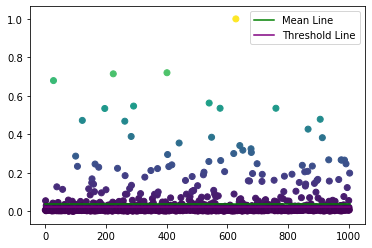

In [21]:
print_res(maxi2,df_error2,y_test)
print("Threshold")
print(maxi2)


print("Mean")
print(mse2.mean())
plt.scatter(range(mse2.shape[0]),mse2,c=mse2)

plt.plot((range(mse2.shape[0])),np.repeat(mse2.mean(),mse2.shape[0]),c='g',label='Mean Line')
plt.plot((range(mse2.shape[0])),np.repeat(maxi2,mse2.shape[0]),c='purple',label='Threshold Line')

plt.legend(loc="upper right")


In [22]:
def calc_res2(df_error,x,test_data):
    #taking the mean value of the reconstruction error as out seperation point for inliers and outliers
    outliers_array = df_error.index[df_error.reconstruction_error > x].tolist()
    test_y2 = test_data.to_numpy()
    #print(outliers2)
    accuracy_positive_count2 = 0
    accuracy_negative_count2 = 0
    for i in range(test_y2.shape[0]):
        if(test_y2[i] == 1):
            if(i in outliers_array[:]):
                accuracy_negative_count2 = accuracy_negative_count2 + 1
        else:
            if(not(i in outliers_array[:])):
                accuracy_positive_count2  = accuracy_positive_count2 + 1

#half of the test data is outliers and half inliers
    accuracy_positive2 = accuracy_positive_count2/(inliers_test)
    accuracy_negative2 = accuracy_negative_count2/(outliers_test)

    return accuracy_positive2
def calc_res3(df_error,x,test_data):
    #taking the mean value of the reconstruction error as out seperation point for inliers and outliers
    outliers_array = df_error.index[df_error.reconstruction_error > x].tolist()
    test_y2 = test_data.to_numpy()
    #print(outliers2)
    accuracy_positive_count2 = 0
    accuracy_negative_count2 = 0
    for i in range(test_y2.shape[0]):
        if(test_y2[i] == 1):
            if(i in outliers_array[:]):
                accuracy_negative_count2 = accuracy_negative_count2 + 1
        else:
            if(not(i in outliers_array[:])):
                accuracy_positive_count2  = accuracy_positive_count2 + 1

#half of the test data is outliers and half inliers
    accuracy_positive2 = accuracy_positive_count2/(inliers_test)
    accuracy_negative2 = accuracy_negative_count2/(outliers_test)

    return accuracy_negative2

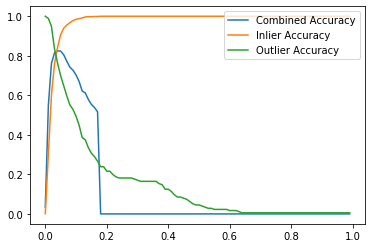

In [23]:
iii = np.arange(0,1,0.01)
va = []
for i in iii:
    va.append(calc_res(df_error,i,y_test))
    
plt.plot(iii,np.array(va),label = 'Combined Accuracy')


iii = np.arange(0,1,0.01)
va2 = []
for i in iii:
    va2.append(calc_res2(df_error,i,y_test))
    
plt.plot(iii,np.array(va2),label = 'Inlier Accuracy')


iii = np.arange(0,1,0.01)
va3 = []
for i in iii:
    va3.append(calc_res3(df_error,i,y_test))
    
plt.plot(iii,np.array(va3),label = 'Outlier Accuracy')
plt.legend(loc="upper right")

In [24]:
#deep autoencoder
encoded3 = Dense(500, activation='relu'
                # ,activity_regularizer=regularizers.l1(1e-3)
                 ,kernel_regularizer=l2(0.01)
                 ,bias_regularizer=l2(0.01)
                )(inputs)
encoded3 = Dense(250, activation='relu'
                # ,activity_regularizer=regularizers.l1(1e-3)
                , kernel_regularizer=l2(0.01) 
                ,bias_regularizer=l2(0.01)
                )(encoded3)
encoded3 = Dense(100, activation='relu'
                # ,activity_regularizer=regularizers.l1(1e-3)
                , kernel_regularizer=l2(0.01) 
                ,bias_regularizer=l2(0.01)
                )(encoded3)
encoded3 = Dense(10, activation='relu'
#                  ,
#                  kernel_regularizer=l2(0.01), 
#                 bias_regularizer=l2(0.01)
                )(encoded3)

#decoded2 = Dense(80, activation='relu')(encoded2)
decoded3 = Dense(100, activation='relu'
               #  ,activity_regularizer=regularizers.l1(0.001)
               # , kernel_regularizer=l2(0.01), 
               # bias_regularizer=l2(0.01)
                )(encoded3)
decoded3 = Dense(250, activation='relu'
                # ,activity_regularizer=regularizers.l1(0.001)
               # , kernel_regularizer=l2(0.01), 
               # bias_regularizer=l2(0.01)
                )(decoded3)
decoded3 = Dense(500, activation='relu'
                # ,activity_regularizer=regularizers.l1(0.001)
               # , kernel_regularizer=l2(0.01), 
               # bias_regularizer=l2(0.01)
                )(decoded3)
decoded3 = Dense(X.shape[1], activation='tanh')(decoded3)

autoencoder3 = Model(inputs, decoded3)
autoencoder3.summary()
autoencoder3.compile(optimizer='adam', loss='mse')

autoencoder3.fit(X_train, X_train,
                epochs=epochs,
                batch_size=256,
                shuffle=False,
                callbacks=callbacks,
                validation_split=0.4
               )




Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 21)]              0         
_________________________________________________________________
dense_10 (Dense)             (None, 500)               11000     
_________________________________________________________________
dense_11 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_12 (Dense)             (None, 100)               25100     
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_14 (Dense)             (None, 100)               1100      
_________________________________________________________________
dense_15 (Dense)             (None, 250)               2525

496/496 [==============================] - 0s 42us/sample - loss: 0.1425 - val_loss: 0.1416
Epoch 65/300
496/496 [==============================] - 0s 44us/sample - loss: 0.1382 - val_loss: 0.1377
Epoch 66/300
496/496 [==============================] - 0s 36us/sample - loss: 0.1342 - val_loss: 0.1340
Epoch 67/300
496/496 [==============================] - 0s 38us/sample - loss: 0.1305 - val_loss: 0.1303
Epoch 68/300
496/496 [==============================] - 0s 42us/sample - loss: 0.1269 - val_loss: 0.1271
Epoch 69/300
496/496 [==============================] - 0s 38us/sample - loss: 0.1235 - val_loss: 0.1238
Epoch 70/300
496/496 [==============================] - 0s 36us/sample - loss: 0.1203 - val_loss: 0.1207
Epoch 71/300
496/496 [==============================] - 0s 40us/sample - loss: 0.1172 - val_loss: 0.1176
Epoch 72/300
496/496 [==============================] - 0s 38us/sample - loss: 0.1141 - val_loss: 0.1147
Epoch 73/300
496/496 [==============================] - 0s 36us/samp

(1004, 1)
Iterations
38
Correct predictions
920
Test Accuracy
0.8926478046833324
Number of Outliers found in Test
151
Number of Outliers acutally in Test
176
Outlier accuracy
0.8579545454545454
Number of Inliers found in Test
769
Number of Inliers acutally in Test
828
Inlier accuracy
0.928743961352657
Number of Inliers classified as Outliers
84
Threshold
0.065
Mean
0.05752662100050768


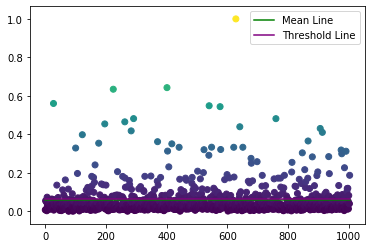

In [25]:
#encoded_data = encoder.predict(test_x)
decoded_data3 = autoencoder3.predict(X_test)

#print(dict(zip(unique, counts)))
mse3 = np.mean(np.power(X_test - decoded_data3, 2), axis=1)

mse3 = mse3.reshape(-1, 1)
print(mse3.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
mse3 = scaler.fit_transform(mse3)


df_error3 = pd.DataFrame({'reconstruction_error': mse3[:,0]})
df_error3.describe()

maxi3 = find_max(calc_res,df_error3.reconstruction_error.max(),df_error3,y_test)

#print(maxi)
#print(calc_res(maxi))
print_res(maxi3,df_error3,y_test)
print("Threshold")
print(maxi3)


print("Mean")
print(mse3.mean())

plt.scatter(range(mse3.shape[0]),mse3,c=mse3)


plt.plot((range(mse3.shape[0])),np.repeat(mse3.mean(),mse3.shape[0]),c='g',label='Mean Line')
plt.plot((range(mse3.shape[0])),np.repeat(maxi3,mse3.shape[0]),c='purple',label='Threshold Line')

plt.legend(loc="upper right")



In [26]:
# iii = np.arange(0,1,0.01)
# va = []
# for i in iii:
#     va.append(calc_res(df_error3,i,y_test))
    
# plt.plot(iii,np.array(va),label = 'Combined Accuracy')


# iii = np.arange(0,1,0.01)
# va2 = []
# for i in iii:
#     va2.append(calc_res2(df_error3,i,y_test))
    
# plt.plot(iii,np.array(va2),label = 'Inlier Accuracy')


# iii = np.arange(0,1,0.01)
# va3 = []
# for i in iii:
#     va3.append(calc_res3(df_error3,i,y_test))
    
# plt.plot(iii,np.array(va3),label = 'Outlier Accuracy')
# plt.legend(loc="upper right")



Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 21)]              0         
_________________________________________________________________
dense_18 (Dense)             (None, 19)                418       
_________________________________________________________________
dense_19 (Dense)             (None, 17)                340       
_________________________________________________________________
dense_20 (Dense)             (None, 15)                270       
_________________________________________________________________
dense_21 (Dense)             (None, 13)                208       
_________________________________________________________________
dense_22 (Dense)             (None, 11)                154       
_________________________________________________________________
dense_23 (Dense)             (None, 9)                 108 

Epoch 54/500
496/496 [==============================] - 0s 52us/sample - loss: 0.6279 - val_loss: 0.6236
Epoch 55/500
496/496 [==============================] - 0s 50us/sample - loss: 0.6190 - val_loss: 0.6149
Epoch 56/500
496/496 [==============================] - 0s 50us/sample - loss: 0.6104 - val_loss: 0.6066
Epoch 57/500
496/496 [==============================] - 0s 46us/sample - loss: 0.6022 - val_loss: 0.5987
Epoch 58/500
496/496 [==============================] - 0s 54us/sample - loss: 0.5942 - val_loss: 0.5910
Epoch 59/500
496/496 [==============================] - 0s 50us/sample - loss: 0.5866 - val_loss: 0.5836
Epoch 60/500
496/496 [==============================] - 0s 46us/sample - loss: 0.5793 - val_loss: 0.5764
Epoch 61/500
496/496 [==============================] - 0s 50us/sample - loss: 0.5722 - val_loss: 0.5695
Epoch 62/500
496/496 [==============================] - 0s 56us/sample - loss: 0.5653 - val_loss: 0.5627
Epoch 63/500
496/496 [==============================] -

496/496 [==============================] - 0s 50us/sample - loss: 0.2785 - val_loss: 0.2790
Epoch 132/500
496/496 [==============================] - 0s 50us/sample - loss: 0.2760 - val_loss: 0.2766
Epoch 133/500
496/496 [==============================] - 0s 50us/sample - loss: 0.2736 - val_loss: 0.2742
Epoch 134/500
496/496 [==============================] - 0s 50us/sample - loss: 0.2713 - val_loss: 0.2719
Epoch 135/500
496/496 [==============================] - 0s 50us/sample - loss: 0.2690 - val_loss: 0.2696
Epoch 136/500
496/496 [==============================] - 0s 48us/sample - loss: 0.2667 - val_loss: 0.2673
Epoch 137/500
496/496 [==============================] - 0s 46us/sample - loss: 0.2644 - val_loss: 0.2651
Epoch 138/500
496/496 [==============================] - 0s 46us/sample - loss: 0.2622 - val_loss: 0.2629
Epoch 139/500
496/496 [==============================] - 0s 46us/sample - loss: 0.2600 - val_loss: 0.2607
Epoch 140/500
496/496 [==============================] - 0s 

496/496 [==============================] - 0s 44us/sample - loss: 0.1655 - val_loss: 0.1674
Epoch 209/500
496/496 [==============================] - 0s 46us/sample - loss: 0.1648 - val_loss: 0.1666
Epoch 210/500
496/496 [==============================] - 0s 50us/sample - loss: 0.1640 - val_loss: 0.1659
Epoch 211/500
496/496 [==============================] - 0s 48us/sample - loss: 0.1633 - val_loss: 0.1651
Epoch 212/500
496/496 [==============================] - 0s 46us/sample - loss: 0.1626 - val_loss: 0.1644
Epoch 213/500
496/496 [==============================] - 0s 44us/sample - loss: 0.1618 - val_loss: 0.1636
Epoch 214/500
496/496 [==============================] - 0s 48us/sample - loss: 0.1611 - val_loss: 0.1630
Epoch 215/500
496/496 [==============================] - 0s 52us/sample - loss: 0.1604 - val_loss: 0.1623
Epoch 216/500
496/496 [==============================] - 0s 48us/sample - loss: 0.1597 - val_loss: 0.1616
Epoch 217/500
496/496 [==============================] - 0s 

496/496 [==============================] - 0s 50us/sample - loss: 0.1313 - val_loss: 0.1335
Epoch 286/500
496/496 [==============================] - 0s 48us/sample - loss: 0.1310 - val_loss: 0.1333
Epoch 287/500
496/496 [==============================] - 0s 46us/sample - loss: 0.1308 - val_loss: 0.1330
Epoch 288/500
496/496 [==============================] - 0s 44us/sample - loss: 0.1306 - val_loss: 0.1328
Epoch 289/500
496/496 [==============================] - 0s 44us/sample - loss: 0.1304 - val_loss: 0.1326
Epoch 290/500
496/496 [==============================] - 0s 42us/sample - loss: 0.1302 - val_loss: 0.1324
Epoch 291/500
496/496 [==============================] - 0s 42us/sample - loss: 0.1300 - val_loss: 0.1322
Epoch 292/500
496/496 [==============================] - 0s 44us/sample - loss: 0.1298 - val_loss: 0.1320
Epoch 293/500
496/496 [==============================] - 0s 44us/sample - loss: 0.1296 - val_loss: 0.1319
Epoch 294/500
496/496 [==============================] - 0s 

496/496 [==============================] - 0s 48us/sample - loss: 0.1219 - val_loss: 0.1243
Epoch 363/500
496/496 [==============================] - 0s 50us/sample - loss: 0.1219 - val_loss: 0.1242
Epoch 364/500
496/496 [==============================] - 0s 48us/sample - loss: 0.1218 - val_loss: 0.1242
Epoch 365/500
496/496 [==============================] - 0s 54us/sample - loss: 0.1218 - val_loss: 0.1241
Epoch 366/500
496/496 [==============================] - 0s 50us/sample - loss: 0.1217 - val_loss: 0.1240
Epoch 367/500
496/496 [==============================] - 0s 50us/sample - loss: 0.1217 - val_loss: 0.1240
Epoch 368/500
496/496 [==============================] - 0s 56us/sample - loss: 0.1216 - val_loss: 0.1239
Epoch 369/500
496/496 [==============================] - 0s 48us/sample - loss: 0.1215 - val_loss: 0.1239
Epoch 370/500
496/496 [==============================] - 0s 48us/sample - loss: 0.1215 - val_loss: 0.1238
Epoch 371/500
496/496 [==============================] - 0s 

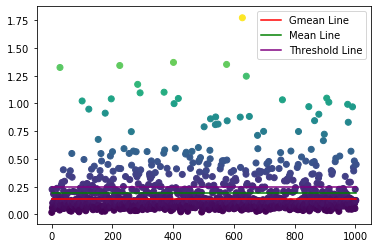

In [27]:
# #deep autoencoder
if(X.shape[1]>14):
    encoded4 = Dense(round(X.shape[1]-2), activation='relu'
                     #,activity_regularizer=regularizers.l1(1e-3)
                     ,kernel_regularizer=l2(0.01)
                     ,bias_regularizer=l2(0.1)
                    )(inputs)
    encoded4 = Dense(round(X.shape[1]-4), activation='relu'
                     #,activity_regularizer=regularizers.l1(1e-3)
                    , kernel_regularizer=l2(0.01) 
                    ,bias_regularizer=l2(0.1)
                    )(encoded4)
    encoded4 = Dense(round(X.shape[1]-6), activation='relu'
                    # ,activity_regularizer=regularizers.l1(1e-3)
                    , kernel_regularizer=l2(0.01) 
                    ,bias_regularizer=l2(0.1)
                    )(encoded4)
    encoded4 = Dense(round(X.shape[1]-8), activation='relu'
                    # ,activity_regularizer=regularizers.l1(1e-3)
                    , kernel_regularizer=l2(0.01) 
                    ,bias_regularizer=l2(0.1)
                    )(encoded4)
    encoded4 = Dense(round(X.shape[1]-10), activation='relu'
                    # ,activity_regularizer=regularizers.l1(1e-3)
                    , kernel_regularizer=l2(0.01) 
                    ,bias_regularizer=l2(0.1)
                    )(encoded4)
    encoded4 = Dense(round(X.shape[1]-12), activation='relu'
                    # ,activity_regularizer=regularizers.l1(1e-3)
                    , kernel_regularizer=l2(0.01) 
                    ,bias_regularizer=l2(0.1)
                    )(encoded4)
    encoded4 = Dense(round(X.shape[1]-14), activation='relu'
                    # ,activity_regularizer=regularizers.l1(1e-3)
                    , kernel_regularizer=l2(0.01) 
                    ,bias_regularizer=l2(0.1)
                    )(encoded4)
    encoded4 = Dense(5, activation='relu'
    #                  ,
    #                  kernel_regularizer=l2(0.01), 
    #                 bias_regularizer=l2(0.01)
                    )(encoded4)

    #decoded2 = Dense(80, activation='relu')(encoded2)
    decoded4 = Dense(round(X.shape[1]-14), activation='relu'
                   #  ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(0.01), 
                   # bias_regularizer=l2(0.01)
                    )(encoded4)
    decoded4 = Dense(round(X.shape[1]-12), activation='relu'
                   #  ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(0.01), 
                   # bias_regularizer=l2(0.01)
                    )(decoded4)
    decoded4 = Dense(round(X.shape[1]-10), activation='relu'
                   #  ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(0.01), 
                   # bias_regularizer=l2(0.01)
                    )(decoded4)

    decoded4 = Dense(round(X.shape[1]-8), activation='relu'
                   #  ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(0.01), 
                   # bias_regularizer=l2(0.01)
                    )(decoded4)                 
    decoded4 = Dense(round(X.shape[1]-6), activation='relu'
                    # ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(0.01), 
                   # bias_regularizer=l2(0.01)
                    )(decoded4)

    decoded4 = Dense(round(X.shape[1]-4), activation='relu'
                    # ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(0.01), 
                   # bias_regularizer=l2(0.01)
                    )(decoded4)
    decoded4 = Dense(round(X.shape[1]-2), activation='relu'
                    # ,activity_regularizer=regularizers.l1(0.001)
                   # , kernel_regularizer=l2(0.01), 
                   # bias_regularizer=l2(0.01)
                    )(decoded4)
    decoded4 = Dense(X.shape[1], activation='tanh')(decoded4)

    autoencoder4 = Model(inputs, decoded4)
    autoencoder4.summary()
    autoencoder4.compile(optimizer='adam', loss='mse')

    autoencoder4.fit(X_train, X_train,
                    epochs=500,
                    batch_size=256,
                    shuffle=True,
                    callbacks=callbacks,
                    validation_split=0.4
                   )
#encoded_data = encoder.predict(test_x)
try:
    autoencoder4
except NameError:
    print("well, autoencoder4 WASN'T defined after all!")
else:
    print("sure, it was defined.")
    decoded_data4 = autoencoder4.predict(X_test)
    print (decoded_data4)
    #print(dict(zip(unique, counts)))
    mse4 = np.mean(np.power(X_test - decoded_data4, 2), axis=1)
    df_error4 = pd.DataFrame({'reconstruction_error': mse4})
    df_error4.describe()

    maxi4 = find_max(calc_res,df_error4.reconstruction_error.max(),df_error4,y_test)

    #print(maxi)
    #print(calc_res(maxi))
    print_res(maxi4,df_error4,y_test)
    print("Threshold")
    print(maxi4)


    print("Mean")
    print(mse4.mean())
    print("Gmean")
    print(gmean(mse4))
    plt.scatter(range(mse4.shape[0]),mse4,c=mse4)

    plt.plot((range(mse4.shape[0])),np.repeat(gmean(mse4),mse4.shape[0]),c='r',label='Gmean Line')
    plt.plot((range(mse4.shape[0])),np.repeat(mse4.mean(),mse4.shape[0]),c='g',label='Mean Line')
    plt.plot((range(mse4.shape[0])),np.repeat(maxi4,mse4.shape[0]),c='purple',label='Threshold Line')

    plt.legend(loc="upper right")

    y_pred_bool4 = np.argmax(decoded_data4, axis=1)
    #print(classification_report(y_test, y_pred_bool4))

In [28]:
ensemble = [];
#print(mse3[1])
for i in range(0,mse.size):
    ensemble.append(0.333*mse[i][0]+0.333*mse2[i][0]+0.333*mse3[i])

#print(ensemble)

In [29]:
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
try:
    mse4
except NameError:
    print("well, it WASN'T defined after all!")
    x = concatenate([decoded, decoded2,decoded3])  # merge the outputs of the two models
else:
    print("sure, it was defined.")
    x = concatenate([decoded, decoded2,decoded3,decoded4])  # merge the outputs of the two models


out = Dense(X.shape[1],activation='tanh')(x)  # final layer of the network
model = Model(inputs=inputs, outputs=out)

model.summary()
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, X_train,
                epochs=500,
                batch_size=256,
                shuffle=True,
                callbacks=callbacks,
                validation_split=0.4
               )

ensemble_pred = model.predict(X_test)
print(ensemble_pred)
ensemble2_mse = np.mean(np.power(X_test - ensemble_pred, 2), axis=1)

sure, it was defined.
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 19)           418         input_1[0][0]                    
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 17)           340         dense_18[0][0]                   
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 15)           270         dense_19[0][0]                   
______________________________________________________________________

496/496 [==============================] - 3s 6ms/sample - loss: 0.6486 - val_loss: 0.4657
Epoch 2/500
496/496 [==============================] - 0s 79us/sample - loss: 0.4371 - val_loss: 0.3406
Epoch 3/500
496/496 [==============================] - 0s 83us/sample - loss: 0.3211 - val_loss: 0.2631
Epoch 4/500
496/496 [==============================] - 0s 87us/sample - loss: 0.2467 - val_loss: 0.2130
Epoch 5/500
496/496 [==============================] - 0s 77us/sample - loss: 0.2014 - val_loss: 0.1841
Epoch 6/500
496/496 [==============================] - 0s 83us/sample - loss: 0.1755 - val_loss: 0.1678
Epoch 7/500
496/496 [==============================] - 0s 81us/sample - loss: 0.1604 - val_loss: 0.1596
Epoch 8/500
496/496 [==============================] - 0s 93us/sample - loss: 0.1523 - val_loss: 0.1523
Epoch 9/500
496/496 [==============================] - 0s 79us/sample - loss: 0.1447 - val_loss: 0.1420
Epoch 10/500
496/496 [==============================] - 0s 81us/sample - loss

496/496 [==============================] - 0s 79us/sample - loss: 0.0281 - val_loss: 0.0327
Epoch 80/500
496/496 [==============================] - 0s 85us/sample - loss: 0.0278 - val_loss: 0.0324
Epoch 81/500
496/496 [==============================] - 0s 73us/sample - loss: 0.0275 - val_loss: 0.0322
Epoch 82/500
496/496 [==============================] - 0s 83us/sample - loss: 0.0272 - val_loss: 0.0320
Epoch 83/500
496/496 [==============================] - 0s 83us/sample - loss: 0.0272 - val_loss: 0.0322
Epoch 84/500
496/496 [==============================] - 0s 89us/sample - loss: 0.0271 - val_loss: 0.0315
Epoch 85/500
496/496 [==============================] - 0s 81us/sample - loss: 0.0264 - val_loss: 0.0314
Epoch 86/500
496/496 [==============================] - 0s 79us/sample - loss: 0.0262 - val_loss: 0.0310
Epoch 87/500
496/496 [==============================] - 0s 69us/sample - loss: 0.0259 - val_loss: 0.0309
Epoch 88/500
496/496 [==============================] - 0s 62us/samp

sure, it was defined.
Model 1
0.8999162823891085
Model 2
0.8410600570926657
Model 3
0.9469079380764164
Model 4
Ensemble
0.9306035902503295
Ensemble2
0.936601064997804
sure, it was defined.


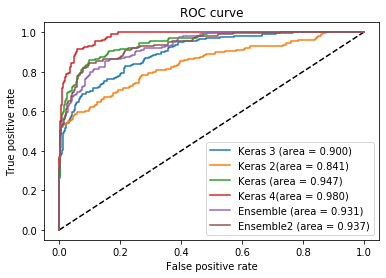

sure, it was defined.


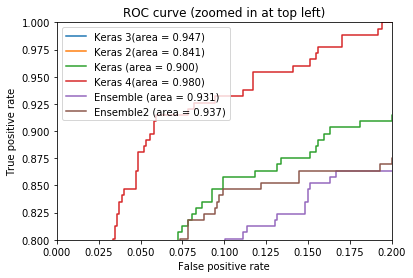

In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr_keras3, tpr_keras3, thresholds_keras3 = roc_curve(y_test, mse3)
fpr_keras2, tpr_keras2, thresholds_keras2 = roc_curve(y_test, mse2)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, mse)
fpr_keras5, tpr_keras5, thresholds_keras5 = roc_curve(y_test, ensemble2_mse)

try:
    mse4
except NameError:
    print("well, it WASN'T defined after all!")
else:
    print("sure, it was defined.")
    fpr_keras4, tpr_keras4, thresholds_keras4 = roc_curve(y_test, mse4)
    auc_keras4 = auc(fpr_keras4, tpr_keras4)

fpr_kerasE, tpr_kerasE, thresholds_kerasE = roc_curve(y_test, ensemble)

#print(thresholds_keras2)


auc_keras = auc(fpr_keras, tpr_keras)
auc_keras2 = auc(fpr_keras2, tpr_keras2)
auc_keras3 = auc(fpr_keras3, tpr_keras3)

auc_kerasE = auc(fpr_kerasE, tpr_kerasE)
auc_keras5 = auc(fpr_keras5, tpr_keras5)


#print(thresholds_keras)
print('Model 1')
print(auc_keras)
print('Model 2')
print(auc_keras2)
print('Model 3')
print(auc_keras3)
print('Model 4')
#print(auc_keras4)
print('Ensemble')
print(auc_kerasE)
print('Ensemble2')
print(auc_keras5)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras 3 (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras2, tpr_keras2, label='Keras 2(area = {:.3f})'.format(auc_keras2))
plt.plot(fpr_keras3, tpr_keras3, label='Keras (area = {:.3f})'.format(auc_keras3))
try:
    mse4
except NameError:
    print("well, it WASN'T defined after all!")
else:
    print("sure, it was defined.")
    plt.plot(fpr_keras4, tpr_keras4, label='Keras 4(area = {:.3f})'.format(auc_keras4))
plt.plot(fpr_kerasE, tpr_kerasE, label='Ensemble (area = {:.3f})'.format(auc_kerasE))
plt.plot(fpr_keras5, tpr_keras5, label='Ensemble2 (area = {:.3f})'.format(auc_keras5))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras 3(area = {:.3f})'.format(auc_keras3))
plt.plot(fpr_keras2, tpr_keras2, label='Keras 2(area = {:.3f})'.format(auc_keras2))
plt.plot(fpr_keras3, tpr_keras3, label='Keras (area = {:.3f})'.format(auc_keras))
try:
    mse4
except NameError:
    print("well, it WASN'T defined after all!")
else:
    print("sure, it was defined.")
    plt.plot(fpr_keras4, tpr_keras4, label='Keras 4(area = {:.3f})'.format(auc_keras4))
plt.plot(fpr_kerasE, tpr_kerasE, label='Ensemble (area = {:.3f})'.format(auc_kerasE))
plt.plot(fpr_keras5, tpr_keras5, label='Ensemble2 (area = {:.3f})'.format(auc_keras5))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

96    0.033763
Name: threshold, dtype: float64


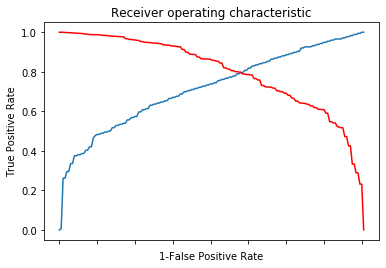

In [31]:
i = np.arange(len(tpr_keras)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr_keras, index=i),'tpr' : pd.Series(tpr_keras, index = i), '1-fpr' : pd.Series(1-fpr_keras, index = i), 'tf' : pd.Series(tpr_keras - (1-fpr_keras), index = i), 'thresholds' : pd.Series(thresholds_keras, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]


# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

roc = pd.DataFrame({'tf' : pd.Series(tpr_keras-(1-fpr_keras), index=i), 'threshold' : pd.Series(thresholds_keras, index=i)})
roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
#list(roc_t['threshold'])
threshold1 = roc_t['threshold']
print(threshold1)
threshold1 = threshold1.to_numpy()
threshold1 = threshold1[0]

83    0.017172
Name: threshold, dtype: float64


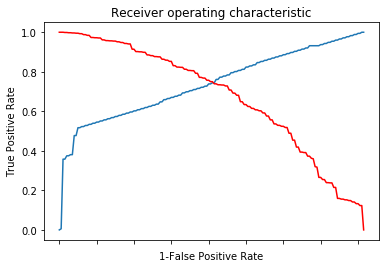

In [32]:
i = np.arange(len(tpr_keras2)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr_keras2, index=i),'tpr' : pd.Series(tpr_keras2, index = i), '1-fpr' : pd.Series(1-fpr_keras2, index = i), 'tf' : pd.Series(tpr_keras2 - (1-fpr_keras2), index = i), 'thresholds' : pd.Series(thresholds_keras2, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]


# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

roc = pd.DataFrame({'tf' : pd.Series(tpr_keras2-(1-fpr_keras2), index=i), 'threshold' : pd.Series(thresholds_keras2, index=i)})
roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
list(roc_t['threshold'])
threshold2 = roc_t['threshold']
print(threshold2)
threshold2 = threshold2.to_numpy()
threshold2 = threshold2[0]

72    0.059437
Name: threshold, dtype: float64


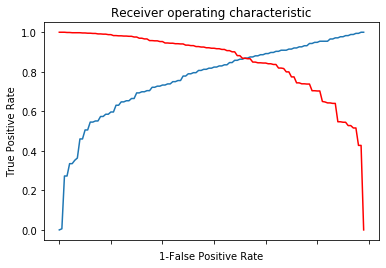

In [33]:
i = np.arange(len(tpr_keras3)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr_keras3, index=i),'tpr' : pd.Series(tpr_keras3, index = i), '1-fpr' : pd.Series(1-fpr_keras3, index = i), 'tf' : pd.Series(tpr_keras3 - (1-fpr_keras3), index = i), 'thresholds' : pd.Series(thresholds_keras3, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]


# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

roc = pd.DataFrame({'tf' : pd.Series(tpr_keras3-(1-fpr_keras3), index=i), 'threshold' : pd.Series(thresholds_keras3, index=i)})
roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
list(roc_t['threshold'])
threshold3 = roc_t['threshold']
print(threshold3)
threshold3 = threshold3.to_numpy()
threshold3 = threshold3[0]

80    0.040532
Name: threshold, dtype: float64


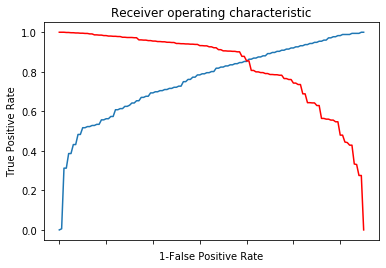

In [34]:
i = np.arange(len(tpr_keras5)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr_keras5, index=i),'tpr' : pd.Series(tpr_keras5, index = i), '1-fpr' : pd.Series(1-fpr_keras5, index = i), 'tf' : pd.Series(tpr_keras5 - (1-fpr_keras5), index = i), 'thresholds' : pd.Series(thresholds_keras5, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]


# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

roc = pd.DataFrame({'tf' : pd.Series(tpr_keras5-(1-fpr_keras5), index=i), 'threshold' : pd.Series(thresholds_keras5, index=i)})
roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
list(roc_t['threshold'])
threshold5 = roc_t['threshold']
print(threshold5)
threshold5 = threshold5.to_numpy()
threshold5 = threshold5[0]

In [35]:
#ensemble

result1 = [];
result2 = [];
result3 = [];

print(threshold1)
for i in range(0,mse.size):
    if(mse[i][0]>threshold1):
        result1.append(1);
    else:
        result1.append(0);
    if(mse2[i][0]>threshold2):
        result2.append(1);
    else:
        result2.append(0);
    if(mse3[i]>threshold3):
        result3.append(1);
    else:
        result3.append(0);

correct =0; 
correct2 =0; 
correct3 =0; 
correct4 =0;
for i in range(0,mse.size):
    if(result1[i] == y_test.to_numpy()[i]):
        correct = correct + 1;
print(correct/mse.size)

for i in range(0,mse.size):
    if(result2[i] == y_test.to_numpy()[i]):
        correct2 = correct2 + 1;
print(correct2/mse.size)


for i in range(0,mse.size):
    if(result3[i] == y_test.to_numpy()[i]):
        correct3 = correct3 + 1;
print(correct3/mse.size)

for i in range(0,mse.size):
    temp = (result1[i] + result2[i] + result3[i] )/3
    if(temp>0.5):
        if(1 == y_test.to_numpy()[i]):
            correct4 = correct4 + 1;
    else:
        if(0 == y_test.to_numpy()[i]):
            correct4 = correct4 + 1;
        
print(correct4/mse.size)


0.033763364373090625
0.796812749003984
0.7410358565737052
0.8675298804780877
0.8077689243027888
